# Examples Using the `dask` Module

#### Presenter: Jason Klima (klimaj@uw.edu)

### We can make use of the `dask` library to parallelize code

In [1]:
import dask
import dask.array as da
import graphviz
import logging
logging.basicConfig(level=logging.INFO)
import os

from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### If you are running this example on a high-performance computing (HPC) cluster with SLURM scheduling:

### The `SLURMCluster` function in the `dask_jobqueue` module is very useful! In this case, we are requesting four workers using `cluster.scale(4)`, and specifying each worker to have:
- one thread per worker with `cores=1`
- one process per worker with `processes=1`
- one CPU per task per worker with `job_cpu=1`
- a total of 4GB memory per worker with `memory="4GB"`
- itself run on the "short" queue/partition on the SLURM scheduler with `queue="short"`
- have a maximum job walltime of 3 hours using `walltime="03:00:00"`
- output files directed to `local_directory`
- output SLURM log files directed to file path and file name (and any other SLURM commands) with the `job_extra` option

#### Note: `dask_jobqueue` also works with other job schedulers besides SLURM: http://jobqueue.dask.org/en/latest/api.html

In [2]:
scratch_dir = os.path.join("/net/scratch", os.environ["USER"])
cluster = SLURMCluster(cores=1,
                       processes=1,
                       job_cpu=1,
                       memory="4GB",
                       queue="short",
                       walltime="03:00:00",
                       local_directory=scratch_dir,
                       job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))])
print(cluster.job_script())
cluster.scale(4)
client = Client(cluster)

#!/bin/bash

#!/usr/bin/env bash
#SBATCH -J dask-worker
#SBATCH -p short
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=4G
#SBATCH -t 03:00:00
#SBATCH -o /net/scratch/klimaj/slurm-%j.out
JOB_ID=${SLURM_JOB_ID%;*}



/home/klimaj/anaconda3/envs/pyrosetta-bootcamp/bin/python -m distributed.cli.dask_worker tcp://172.16.131.35:30619 --nthreads 1 --memory-limit 4.00GB --name dask-worker--${JOB_ID}-- --death-timeout 60 --local-directory /net/scratch/klimaj



### Otherwise, if you are running this example locally on your laptop, you can still spawn workers and take advantage of the `dask` module:

In [3]:
# cluster = LocalCluster(n_workers=2, threads_per_worker=2)
# client = Client(cluster)

### Open the dask dashboard, which shows diagnostic information about the current state of your cluster and helps track progress, identify performance issues, and debug failures

In [3]:
client

Client Scheduler: tcp://172.16.131.35:30619 Dashboard: http://172.16.131.35:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GB


### Consider the following example that runs within this Jupyter notebook kernel just fine but could be parallelized:

In [4]:
def inc(x):
    return x + 1


def double(x):
    return x + 2


def add(x, y):
    return x + y

In [5]:
output = []
for x in range(10):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
print(total)

120


### With a slight modification, we can parallelize it on the HPC cluster using the `dask` module

In [6]:
output = []
for x in range(10):
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

delayed = dask.delayed(sum)(output)
print(delayed)

Delayed('sum-04f95cb9-93bb-472c-84f9-1192dc8eeea8')


### We used the `dask.delayed` function to wrap the function calls that we want to turn into tasks. None of the `inc`, `double`, `add`, or `sum` calls have happened yet. Instead, the object total is a `Delayed` object that contains a task graph of the entire computation to be executed.

### Let's visualize the task graph to see clear opportunities for parallel execution.

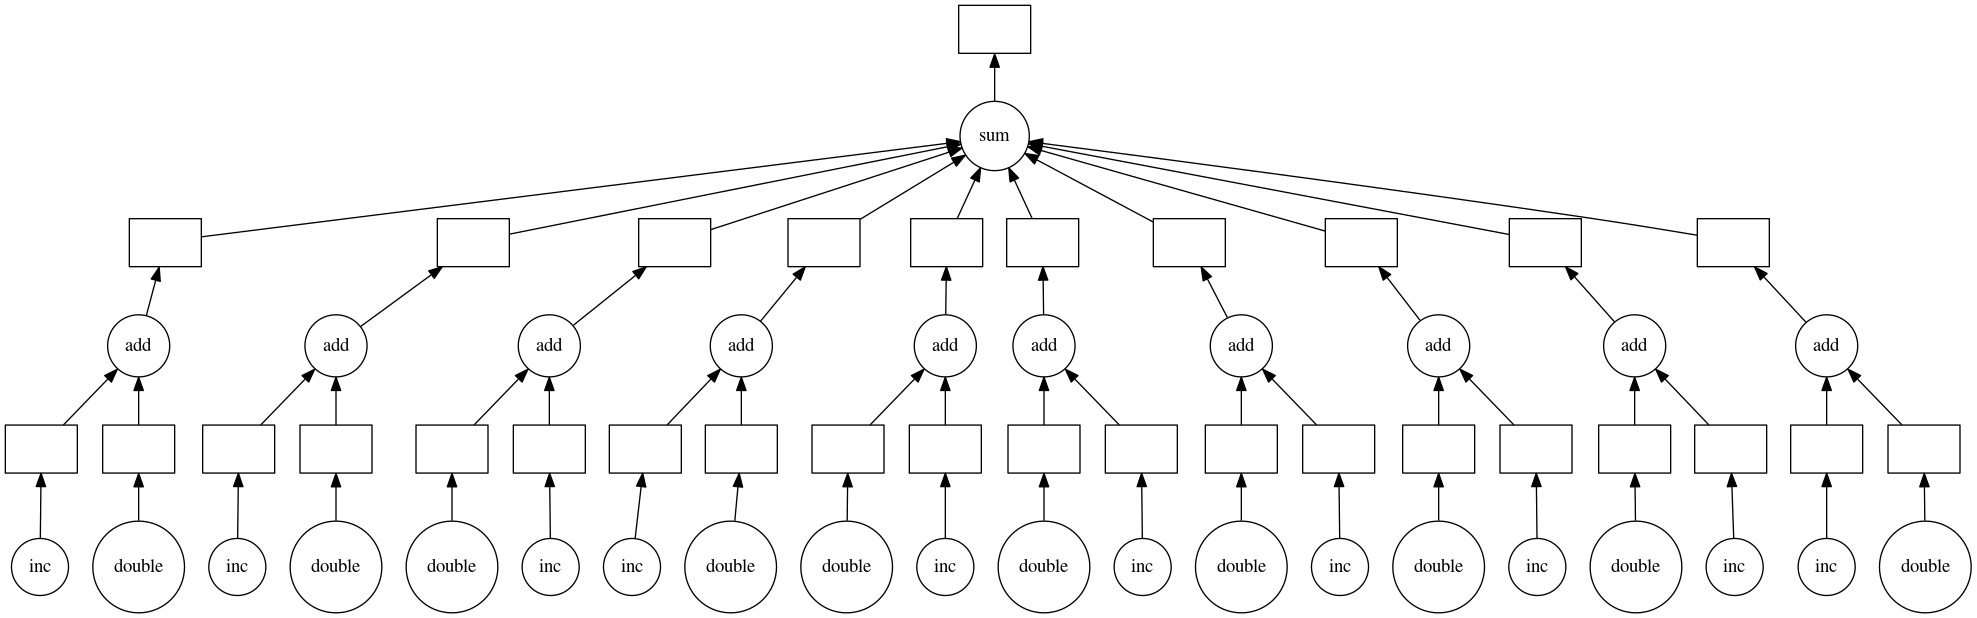

In [7]:
delayed.visualize()

### We can now compute this lazy result to execute the graph in parallel:

In [8]:
total = delayed.compute()
print(total)

120


### We can also use `dask.delayed` as a python function decorator for identical performance

In [9]:
@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x + 2

@dask.delayed
def add(x, y):
    return x + y

output = []
for x in range(10):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output).compute()
print(total)

120


### We can also use the `dask.array` library, which implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many parallelizable small arrays.
### See `dask.array` documentation: http://docs.dask.org/en/latest/array.html, along with that of `dask.bag`, `dask.dataframe`, `dask.delayed`, Futures, etc.

In [11]:
x = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
y = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1, 2))
z.compute()

array([157263.87905519, 157205.56581877, 157055.56750494, ...,
       157153.44359458, 157203.70238804, 157116.13885104])